# A Convolutional Autoencoder for Anomaly Detection

Anomaly detection is the task of finding anomalous data elements in a dataset. An anomaly is a data element that is an outlier with respect to the rest of the dataset.

We are going to train an autoencoder on the MNIST dataset (that only contains numbers), and then we will look into anomalies within the MNIST dataset (i.e., images within MNIST that are somehow different than the rest of the dataset).

Even though MNIST is a labeled dataset, we are going to disregard the labels for educational purposes and consider it as an unlabeled datasets.

**This time we are going to use a CNN-based auto-encoder.**

In [1]:
!pip install -r requirements.txt | grep -v "already"

> After installing the dependencies you need to restart your kernel. The following cell does that for you.

In [1]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True) #automatically restarts kernel

{'status': 'ok', 'restart': True}

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch import nn
import torchvision.models
import torchvision.transforms as transforms
import multiprocessing
from tqdm import tqdm
from helpers import get_data_loaders
from helpers import seed_all
from helpers import anomaly_detection_display
import pandas as pd

# Ensure repeatibility
seed_all(42)

In [2]:
# This will get data loaders for the MNIST dataset for the train, validation
# and test dataset
data_loaders = get_data_loaders(batch_size=1024)

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize the Data

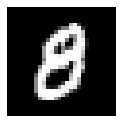

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loaders['train'])
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig, sub = plt.subplots(figsize = (2,2)) 
sub.imshow(img, cmap='gray')
_ = sub.axis("off")

---
## Convolutional Autoencoder

Write your own CNN autoencoder. Use at least 2 blocks Convolution + ReLU + MaxPooling as _encoder_, and then an equivalent number of upsampling operations (either Transposed Convolutions+ReLU or Upsample+Conv+ReLU) followed by a Sigmoid activation.

In [4]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        ## encoder ##
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2)
        )
        
        ## decoder ##
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Upsample(scale_factor = 2, mode='nearest'),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )
        
        self.auto_encoder = nn.Sequential(
            self.encoder,
            self.decoder
        )

    def forward(self, x):
        # define feedforward behavior 
        # and scale the *output* layer with a sigmoid activation function
        
        return self.auto_encoder(x)
    
# initialize the NN
model = Autoencoder()

## Loss Function

As explained in the lesson, we can use the Mean Squared Error loss, which is called `MSELoss` in PyTorch:

In [5]:
# specify loss function
criterion = nn.MSELoss()

## Training

The training loop is similar to a normal training loop, however, this task is an unsupervised task. That means we do not need labels. The MNIST dataset does provide labels, of course, so we will just disregard them.

In [6]:
# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)

In [7]:
# number of epochs to train the model
n_epochs = 50

for epoch in range(1, n_epochs + 1):
    # monitor training loss
    train_loss = 0.0
    
    if torch.cuda.is_available():
        model = model.cuda()
    
    model.train()
        
    ###################
    # train the model #
    ###################
    for data in tqdm(desc="Training", total=len(data_loaders['train']), iterable=data_loaders['train']):
        # we disregard the labels. We use the Python convention of calling
        # an unused variable "_"
        images, _ = data
        
        if torch.cuda.is_available():
            images = images.cuda()
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)

        # calculate the loss
        loss = criterion(outputs.flatten(), images.flatten())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * images.size(0)
    
    # Validation
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(desc="Validating", total=len(data_loaders['valid']), iterable=data_loaders['valid']):
            # _ stands in for labels, here
            images, _ = data
            
            if torch.cuda.is_available():
                images = images.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs.flatten(), images.flatten())
            
            # update running training loss
            val_loss += loss.item() * images.size(0)
    
    # print avg training statistics
    train_loss /= len(data_loaders['train'])
    val_loss /= len(data_loaders['valid'])
    print("Epoch: {} \tTraining Loss: {:.6f}\tValid Loss: {:.6f}".format(epoch, train_loss, val_loss))

Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.53it/s]


Epoch: 1 	Training Loss: 63.463890	Valid Loss: 26.926150


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.90it/s]


Epoch: 2 	Training Loss: 19.242368	Valid Loss: 10.886718


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.97it/s]


Epoch: 3 	Training Loss: 9.029493	Valid Loss: 6.381938


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.41it/s]


Epoch: 4 	Training Loss: 6.908796	Valid Loss: 6.052194


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.65it/s]


Epoch: 5 	Training Loss: 5.308278	Valid Loss: 4.623463


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.07it/s]


Epoch: 6 	Training Loss: 4.995809	Valid Loss: 4.651799


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.86it/s]


Epoch: 7 	Training Loss: 4.417410	Valid Loss: 4.622144


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.65it/s]


Epoch: 8 	Training Loss: 4.258979	Valid Loss: 3.721516


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.60it/s]


Epoch: 9 	Training Loss: 3.679365	Valid Loss: 3.645559


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.07it/s]


Epoch: 10 	Training Loss: 3.660445	Valid Loss: 3.947705


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.89it/s]


Epoch: 11 	Training Loss: 3.643928	Valid Loss: 3.254059


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.61it/s]


Epoch: 12 	Training Loss: 3.368400	Valid Loss: 3.168399


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.01it/s]


Epoch: 13 	Training Loss: 3.090921	Valid Loss: 3.108997


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.15it/s]


Epoch: 14 	Training Loss: 3.043601	Valid Loss: 2.806177


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.91it/s]


Epoch: 15 	Training Loss: 2.923189	Valid Loss: 2.861483


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.98it/s]


Epoch: 16 	Training Loss: 2.845345	Valid Loss: 2.754618


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.18it/s]


Epoch: 17 	Training Loss: 2.679983	Valid Loss: 2.550836


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.53it/s]


Epoch: 18 	Training Loss: 2.731695	Valid Loss: 2.570820


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.95it/s]


Epoch: 19 	Training Loss: 2.537637	Valid Loss: 2.363051


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.70it/s]


Epoch: 20 	Training Loss: 2.472380	Valid Loss: 2.387816


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.62it/s]


Epoch: 21 	Training Loss: 2.390809	Valid Loss: 2.521081


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.96it/s]


Epoch: 22 	Training Loss: 2.334149	Valid Loss: 2.205090


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.39it/s]


Epoch: 23 	Training Loss: 2.238134	Valid Loss: 2.131365


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.09it/s]


Epoch: 24 	Training Loss: 2.264384	Valid Loss: 2.110665


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.62it/s]


Epoch: 25 	Training Loss: 2.170510	Valid Loss: 2.033233


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.51it/s]


Epoch: 26 	Training Loss: 2.124253	Valid Loss: 2.080516


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.71it/s]


Epoch: 27 	Training Loss: 2.097899	Valid Loss: 2.184166


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.91it/s]


Epoch: 28 	Training Loss: 2.068252	Valid Loss: 2.018422


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.00it/s]


Epoch: 29 	Training Loss: 1.988497	Valid Loss: 2.071299


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.24it/s]


Epoch: 30 	Training Loss: 2.016501	Valid Loss: 1.952776


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.78it/s]


Epoch: 31 	Training Loss: 1.978777	Valid Loss: 1.877106


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.83it/s]


Epoch: 32 	Training Loss: 1.875003	Valid Loss: 1.804387


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.15it/s]


Epoch: 33 	Training Loss: 1.943704	Valid Loss: 1.779884


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.21it/s]


Epoch: 34 	Training Loss: 1.915803	Valid Loss: 1.795287


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.43it/s]


Epoch: 35 	Training Loss: 1.860219	Valid Loss: 1.942081


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.52it/s]


Epoch: 36 	Training Loss: 1.854498	Valid Loss: 1.798145


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.99it/s]


Epoch: 37 	Training Loss: 1.823314	Valid Loss: 1.746064


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.84it/s]


Epoch: 38 	Training Loss: 1.798351	Valid Loss: 1.682395


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.66it/s]


Epoch: 39 	Training Loss: 1.719838	Valid Loss: 1.687386


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.07it/s]


Epoch: 40 	Training Loss: 1.700151	Valid Loss: 1.704008


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.90it/s]


Epoch: 41 	Training Loss: 1.742529	Valid Loss: 1.675373


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.09it/s]


Epoch: 42 	Training Loss: 1.682745	Valid Loss: 1.603320


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.85it/s]


Epoch: 43 	Training Loss: 1.712782	Valid Loss: 1.662144


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.20it/s]


Epoch: 44 	Training Loss: 1.647681	Valid Loss: 1.561047


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.59it/s]


Epoch: 45 	Training Loss: 1.607799	Valid Loss: 1.632121


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.84it/s]


Epoch: 46 	Training Loss: 1.603571	Valid Loss: 1.526855


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.49it/s]


Epoch: 47 	Training Loss: 1.594924	Valid Loss: 1.630757


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.50it/s]


Epoch: 48 	Training Loss: 1.599681	Valid Loss: 1.543989


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.92it/s]


Epoch: 49 	Training Loss: 1.597946	Valid Loss: 1.562743


Validating: 100%|███████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 10.83it/s]

Epoch: 50 	Training Loss: 1.581296	Valid Loss: 1.522172


In [8]:
# Epoch: 50 	Training Loss: 1.359510	Valid Loss: 1.399772

## Finding anomalies
Now that our auto-encoder is trained we can use it to find anomalies. Let's consider the test set. We loop over all the batches in the test set and we record the value of the loss for each example separately. The examples with the highest reconstruction loss are our anomalies. 

Indeed, if the reconstruction loss is high, that means that our trained auto-encoder could not reconstruct them well. Indeed, what the autoencoder learned about our dataset during training is not enough to describe these examples, which means they are different than what the encoder has seen during training, i.e., they are anomalies (or at least they are the most uncharacteristic examples).

Let's have a look:

In [9]:
# Since this dataset is small we collect all the losses as well as
# the image and its reconstruction in a dictionary. In case of a
# larger dataset you might have to save on disk
# (won't fit in memory)
losses = {}

# We need the loss by example (not by batch)
loss_no_reduction = nn.MSELoss(reduction='none')

idx = 0

with torch.no_grad():
    for data in tqdm(desc="Testing", total=len(data_loaders['test']),
            iterable=data_loaders['test']
        ):

            images, labels = data
            
            if torch.cuda.is_available():
                images = images.cuda()
                        
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            
            # calculate the loss
            loss = loss_no_reduction(outputs, images)
            
            # Accumulate results per-example
            for i, l in enumerate(loss.mean(dim=[1, 2, 3])):
                losses[idx + i] = {
                    'loss': float(l.cpu().numpy()),
                    'image': images[i].cpu().numpy(),
                    'reconstructed': outputs[i].cpu().numpy()
                }
            
            idx += loss.shape[0]

# Let's save our results in a pandas DataFrame
df = pd.DataFrame(losses).T
df.head()

Testing: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.50it/s]


,loss,image,reconstructed
0,0.001066,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.00369219, 0.0016306575, 0.0016175738, 0.0..."
1,0.00178,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.003288547, 0.0014011347, 0.0014624811, 0...."
2,0.00064,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.003668256, 0.0015365853, 0.0014934457, 0...."
3,0.001966,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0036572078, 0.0015396264, 0.0014838143, 0..."
4,0.001458,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.003665664, 0.0015493687, 0.001460742, 0.0..."


Let's now display the histogram of the loss. The elements on the right (with the higher loss) are the most uncharacteristic examples. Feel free to look into `helpers.py` to see how these plots are made:

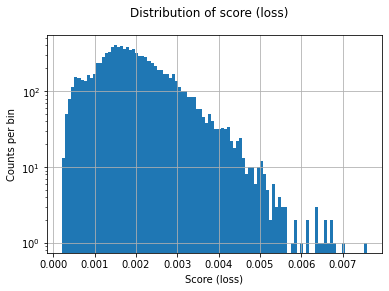

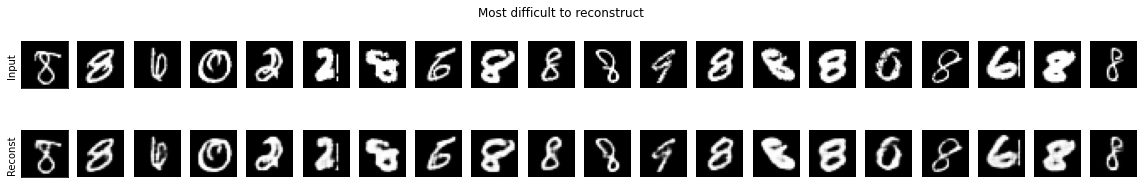

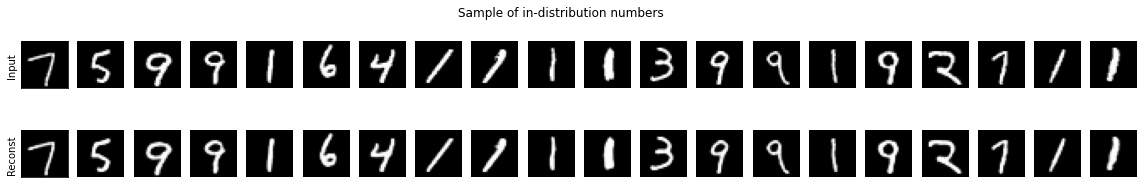

In [10]:
from helpers import anomaly_detection_display

anomaly_detection_display(df)

We got similar results as in the case of linear auto-encoders, but the loss is on average much smaller (a sign that the network is much more capable of representing and reconstructing the dataset).